In [1]:
import sys

import torch  # noqa: E402
import random  # noqa: E402
import numpy as np  # noqa: E402
import matplotlib.pyplot as plt
import ot
import importlib

from pydil.utils.Online_GMM import Online_GMM
from pydil.utils.igmm_modif import IGMM

from pydil.ipms.ot_ipms import (  # noqa: E402
    JointWassersteinDistance
)
from pydil.dadil.labeled_dictionary import LabeledDictionary  # noqa: E402
from pydil.dadil.labeled_dictionary_GMM import LabeledDictionaryGMM
from pydil.ot_utils.barycenters import wasserstein_barycenter  # noqa: E402
from pydil.torch_utils.measures import (  # noqa: E402
    UnsupervisedDatasetMeasure,
    SupervisedDatasetMeasure
)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())
C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = np.load('toy_non_linear_1000d_dataset.npy')

In [3]:
X = dataset[:, :-2]
y = dataset[:, -2]
d = dataset[:, -1]

n_domains = int(np.max(d)) + 1
n_features = X.shape[1]

In [4]:
X.shape, y.shape, d.shape

((6000, 1000), (6000,), (6000,))

In [5]:
Xs, ys = [], []
for i in range(n_domains-1):
    Xs.append(torch.from_numpy(X[np.where(d == i)[0]]).float())
    ys.append(torch.from_numpy(y[np.where(d == i)[0]]).float())

In [6]:
Xt = torch.from_numpy(X[np.where(d == n_domains-1)[0]]).float()
yt = torch.from_numpy(y[np.where(d == n_domains-1)[0]]).float()

In [7]:
combined_arrays = list(zip(Xt, yt))

random.seed(0)
# Shuffle the combined arrays
random.shuffle(combined_arrays)

# Unzip the shuffled arrays back into separate arrays
Xt, yt = zip(*combined_arrays)
Xt = torch.stack(Xt, axis=0)
yt = torch.stack(yt, axis=0)

In [8]:
n_samples = 1000
batch_size = 200
n_atoms = 3
n_classes = 10

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_t = torch.from_numpy(X_train)
X_test_t = torch.from_numpy(X_test)
X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[np.where(d==n_domains-1)[0], :], y[np.where(d==n_domains-1)[0]], test_size=0.2, random_state=0)
X_train_target_t = torch.from_numpy(X_train_target)
X_test_target_t = torch.from_numpy(X_test_target)
dim_reduction = 3

In [10]:
OGMM = IGMM(min_components=10, max_step_components=5, max_components=20)

n_batch = 20
i=0
while i < Xt.shape[0]-n_batch:
    OGMM.fit(Xt[i:i+n_batch, :])
    i += n_batch

OGMM.get_GMM()

[[0.025577277100292437,
  array([ 1.86393797e+00, -2.53766745e+00,  4.02615945e+00, -7.52126980e+00,
          1.11686805e+01,  5.01245196e-01, -9.60538658e+00, -4.49900357e+00,
         -1.11053093e+01, -4.41320491e+00, -1.27878494e+01, -7.42531292e+00,
         -2.63986107e+00, -4.26237389e-01,  4.13606882e+00, -7.12761641e+00,
         -9.53518216e+00, -3.36690224e+00, -2.09322220e+00, -1.17590349e+00,
          2.54301302e+00, -5.08201218e+00,  3.77451885e+00,  8.09357460e+00,
          1.19514637e+00, -8.77987568e+00,  1.09450575e+00, -8.79243445e+00,
         -7.41333397e+00, -3.75090756e+00, -1.46070984e+01,  7.20786087e+00,
          2.12355047e+00,  1.20194803e+00, -1.26229065e+01, -4.59019546e+00,
         -9.51700735e+00, -5.98869646e+00, -8.88635834e+00, -1.37246256e+01,
         -6.93522286e+00,  1.66044357e+00, -7.78623398e+00, -8.01343989e+00,
         -5.66153844e+00, -2.77477038e+00, -5.67040475e+00, -4.40406811e+00,
         -6.60911139e+00,  3.67204611e+00, -6.450990

In [11]:
OGMM.weights_

array([0.02557728, 0.00426288, 0.00426288, 0.79701009, 0.00426288,
       0.00426288, 0.00426288, 0.00426288, 0.00852576, 0.14330959])

In [12]:
%%script false --no-exec

range_data = np.mean(np.max(X[np.where(d!=n_domains-1)[0], :], axis=0) - np.min(X[np.where(d!=n_domains-1)[0], :], axis=0))

dim_reduction = 3
n_gaussians = 10
OGMM = Online_GMM(
    n_components=n_gaussians, 
    lr=0.1,
    n_features=dim_reduction,
    data_range=range_data,
    batch_size=batch_size
)

i=0
while i < Xt.shape[0]-dim_reduction:
    OGMM.fit_sample(Xt[i:i+dim_reduction, :], dimension_reduction=True)
    i += dim_reduction
OGMM.get_GMM()

Couldn't find program: 'false'


In [15]:
n_gaussians = 10
sklearn_GMM = GaussianMixture(n_components=n_gaussians, random_state=0)
sklearn_GMM.fit(Xt)

GaussianMixture(n_components=10, random_state=0)

## Tests on the GMM

In [ ]:
np.sum(OGMM.score_samples(Xt, dimension_reduction=True))

In [ ]:
np.sum(OGMM.score_samples(Xt.numpy()))

In [16]:
np.sum(sklearn_GMM.score_samples(Xt))

5922874.604398262

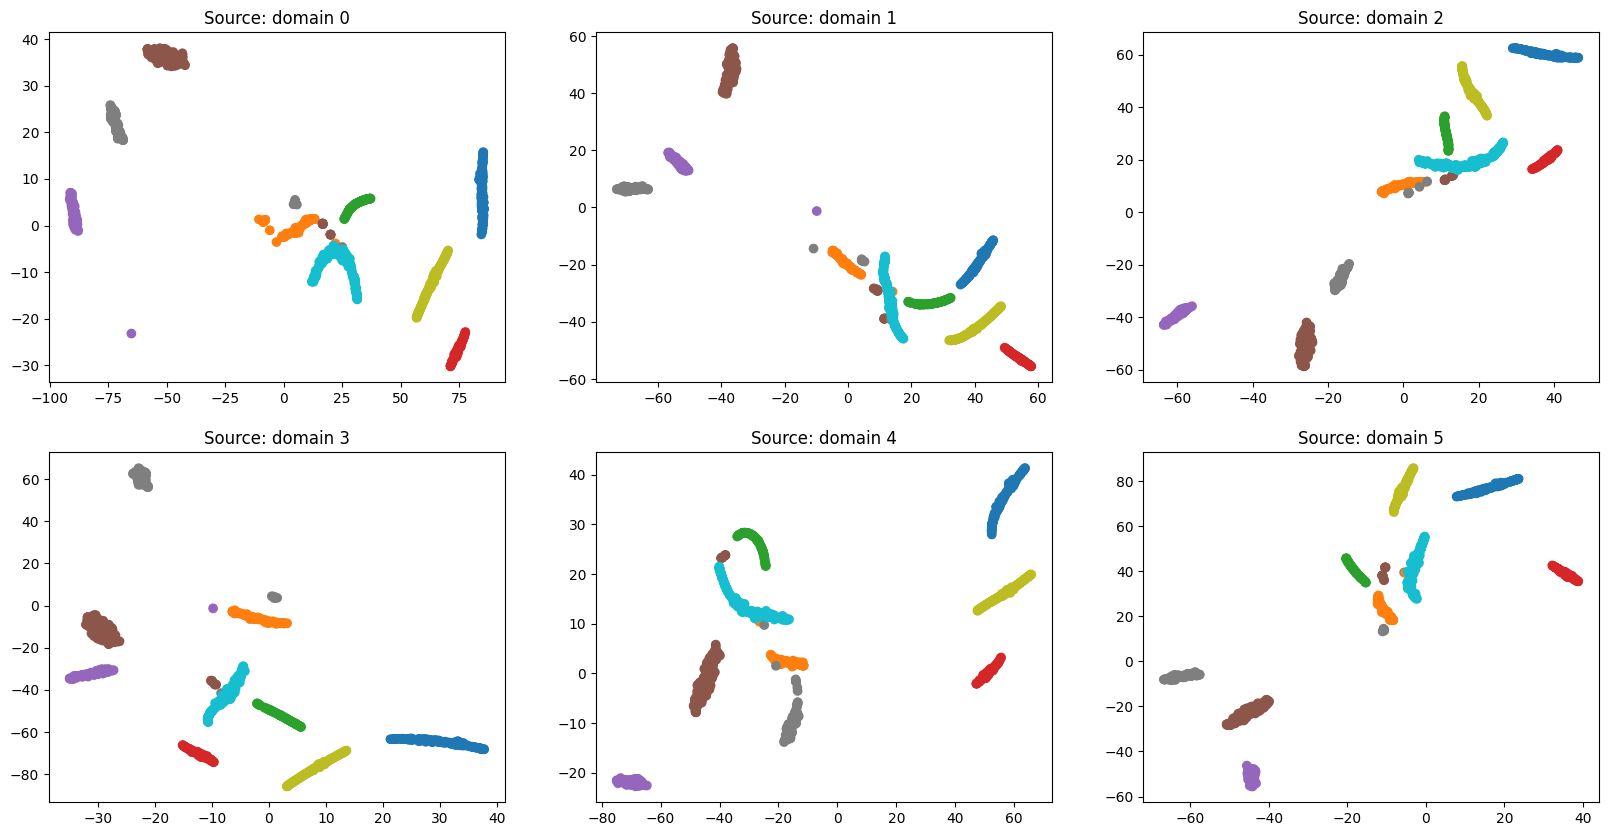

In [22]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [Xt], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys + [yt], dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')


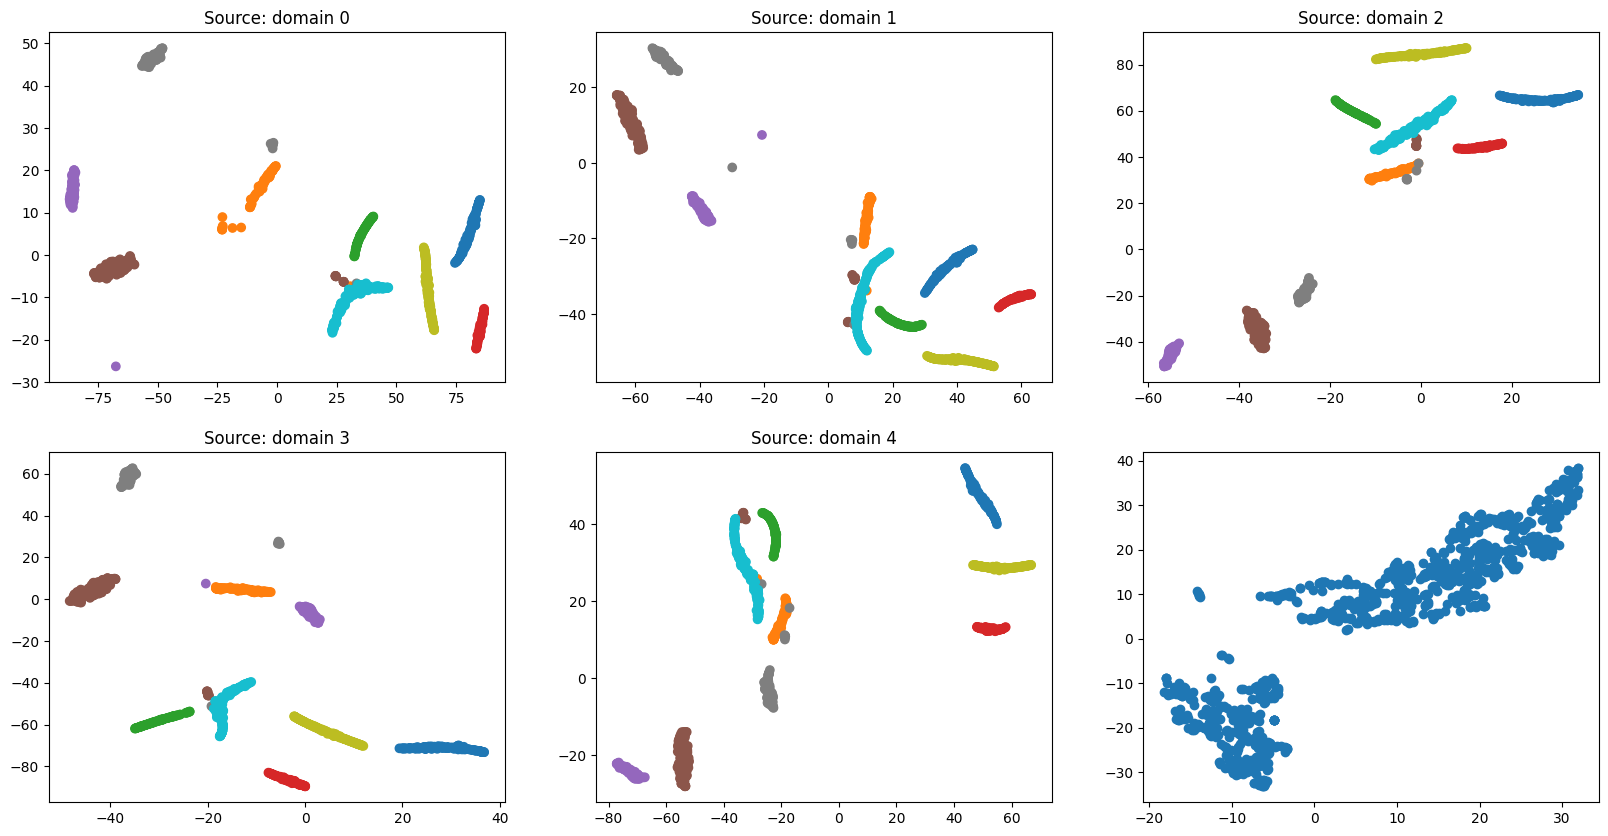

In [23]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [OGMM.sample(1000)[0]], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-1]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == n_domains-1)[0]
axes.flatten()[-1].scatter(proj[ind, 0],
               proj[ind, 1])

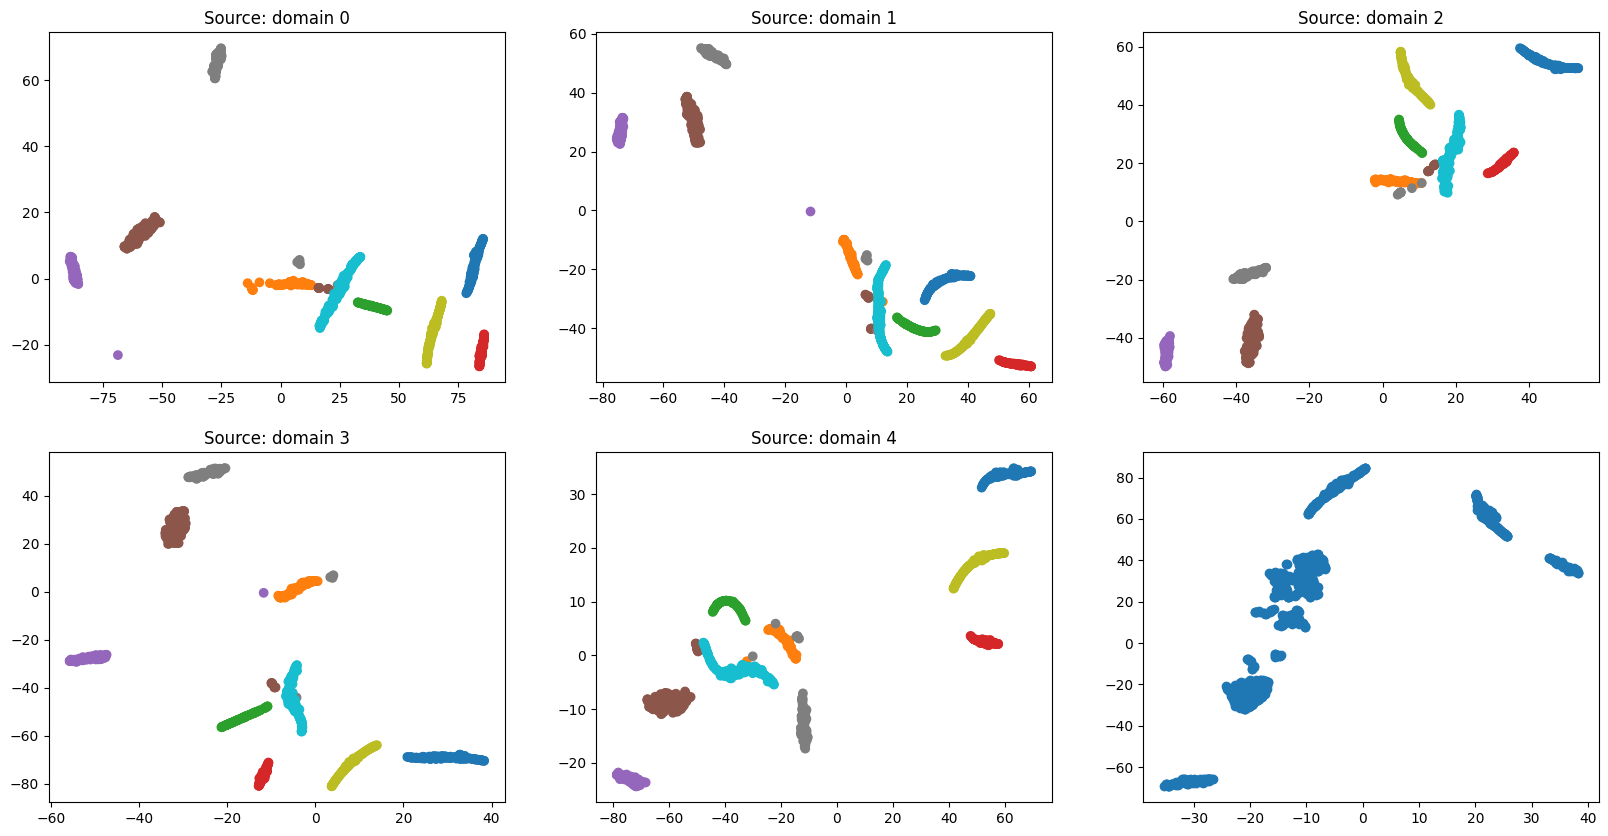

In [24]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [torch.from_numpy(sklearn_GMM.sample(1000)[0]).float()], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-1]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == n_domains-1)[0]
axes.flatten()[-1].scatter(proj[ind, 0],
               proj[ind, 1])

Test to determine the best n_gaussians

In [ ]:
%%script false --no-exec
range_data = np.mean(np.max(X[np.where(d!=6)[0], :], axis=0) - np.min(X[np.where(d!=6)[0], :], axis=0))

n_gaussians = np.linspace(10, 60, 6)
ll = []
for n_gauss in n_gaussians:
    OGMM = Online_GMM(
        n_components=n_gauss, 
        lr=0.1,
        n_features=dim_reduction,
        data_range=range_data,
        batch_size=batch_size
    )
    
    i = 0
    while i < X_train_target_t.shape[0]-dim_reduction:
        OGMM.fit_sample(X_train_target_t[i:i+dim_reduction, :], dimension_reduction=True)
        i += dim_reduction

    print(OGMM.get_GMM())
    ll.append(OGMM.score_samples(X_test_target_t, dimension_reduction=True))

## Dictionary learning seperated between sources and target with Online_GMM simultaneously

In [64]:
Q_sources = []
for Xs_k, ys_k in zip(Xs, ys):
    Q_sources.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )

criterion = JointWassersteinDistance()

dictionary_sources = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=n_classes,
                           n_components=n_atoms,
                           weight_initialization='uniform',
                           n_distributions=len(Q_sources),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

dictionary_sources.fit(Q_sources,
               n_iter_max=25,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/25, Loss: 13389692.000000002
It 2/25, Loss: 8914920.8
It 3/25, Loss: 5984126.399999999
It 4/25, Loss: 4282665.1
It 5/25, Loss: 3582637.3000000003
It 6/25, Loss: 3218535.5
It 7/25, Loss: 3002468.0500000003
It 8/25, Loss: 2872185.65
It 9/25, Loss: 2852038.15
It 10/25, Loss: 2763533.1000000006
It 11/25, Loss: 2761661.15
It 12/25, Loss: 2740907.5
It 13/25, Loss: 2669976.8500000006
It 14/25, Loss: 2624490.25
It 15/25, Loss: 2572951.55
It 16/25, Loss: 2553039.7
It 17/25, Loss: 2542449.0
It 18/25, Loss: 2539040.9
It 19/25, Loss: 2514134.95
It 20/25, Loss: 2443544.85
It 21/25, Loss: 2446553.2
It 22/25, Loss: 2444197.65
It 23/25, Loss: 2420608.0500000003
It 24/25, Loss: 2384303.4
It 25/25, Loss: 2361454.05


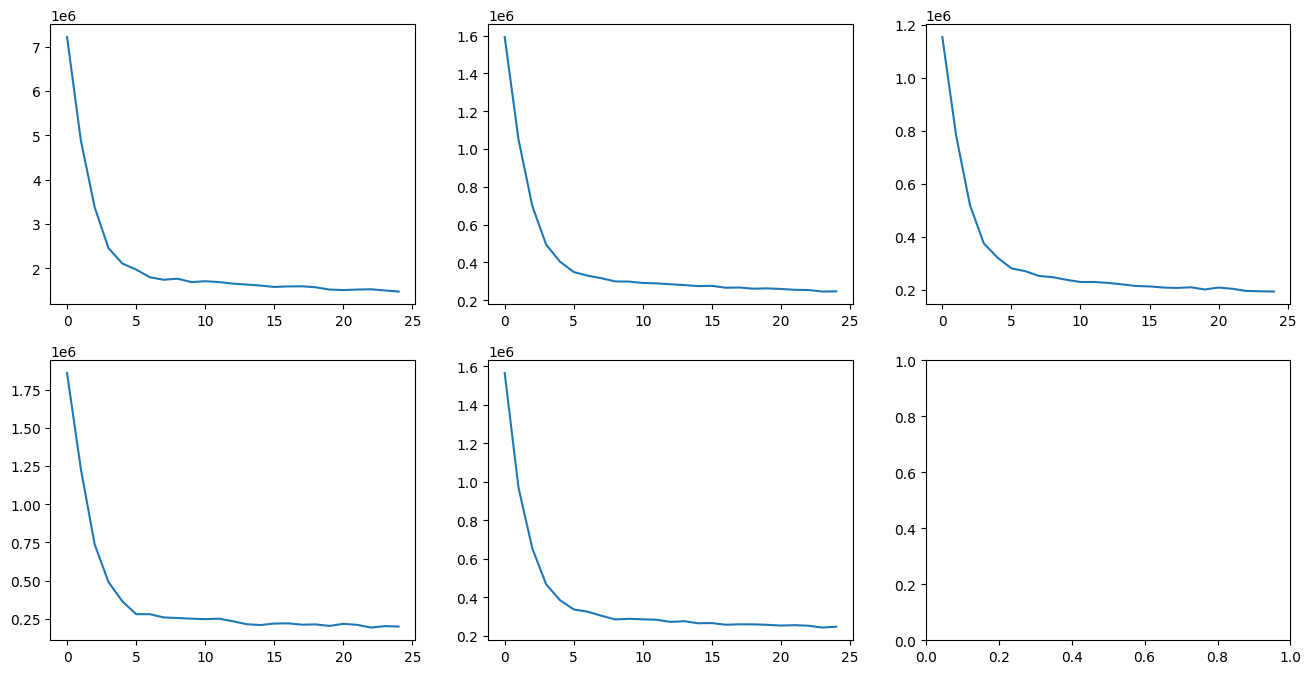

In [65]:
XP_sources = dictionary_sources.XP
YP_sources = dictionary_sources.YP

names_sources = [f'domain {i}' for i in range(6)]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary_sources.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary_sources.history['loss_per_dataset'][dom])

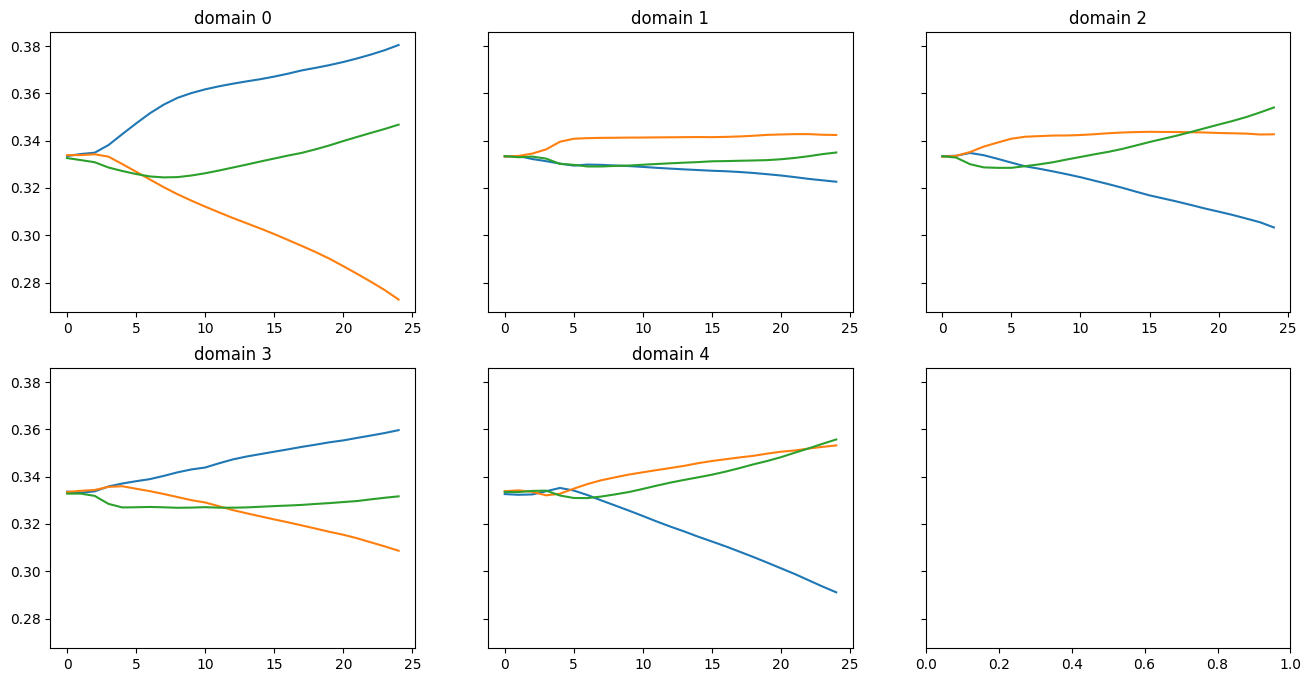

In [66]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names_sources, axes.flatten()[:-1])):
    ax.plot(torch.stack(dictionary_sources.history['weights'])[:, k, :])
    ax.set_title(name)

In [67]:
dictionary_target = LabeledDictionaryGMM(XP=XP_sources,
                                        YP=YP_sources,
                                        A=None,
                                        n_samples=n_samples,
                                        n_dim=X.shape[1],
                                        n_classes=n_classes,
                                        n_components=n_atoms,
                                        weight_initialization='uniform',
                                        n_distributions=1,
                                        loss_fn=criterion,
                                        learning_rate_features=0,
                                        learning_rate_labels=0,
                                        learning_rate_weights=1e-1,
                                        reg_e=0.0,
                                        n_iter_barycenter=10,
                                        n_iter_sinkhorn=20,
                                        n_iter_emd=1000000,
                                        domain_names=None,
                                        grad_labels=True,
                                        optimizer_name='Adam',
                                        balanced_sampling=True,
                                        sampling_with_replacement=True,
                                        barycenter_tol=1e-9,
                                        barycenter_beta=None,
                                        tensor_dtype=torch.float32,
                                        track_atoms=False,
                                        schedule_lr=False,
                                        min_components=10,
                                        max_step_components=10,
                                        max_components=20)

i = 0
while i < Xt.shape[0]-n_batch:
    print(i)
    dictionary_target.fit_target_sample(Xt[i:i+n_batch, :],
                                        batches_per_it=n_samples // batch_size,
                                        batch_size=batch_size,
                                        verbose=True,
                                        regularization=False,)
    i += n_batch

0
Loss: 164016.21250000002
20
Loss: 145970.35625
40
Loss: 143517.7734375
60
Loss: 127518.109375
80
Loss: 128161.66718749999
100
Loss: 142725.31875
120
Loss: 148800.609375
140
Loss: 121269.5203125
160
Loss: 116531.70156249999
180


KeyboardInterrupt: 

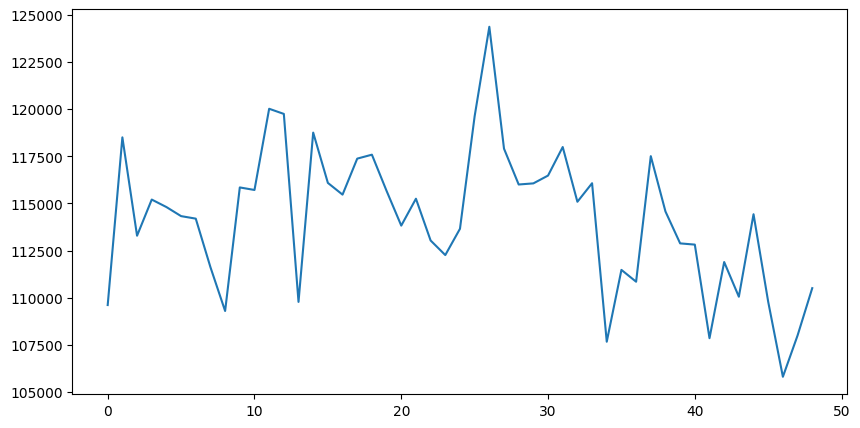

In [ ]:
target_name = 'Domain 7'
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dictionary_target.history['loss_per_dataset']['Domain 0'])

Text(0.5, 1.0, 'Domain 7')

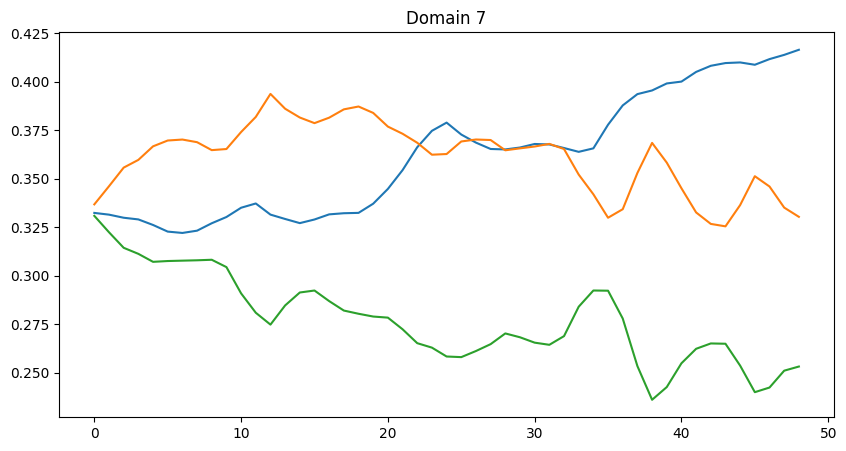

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(torch.stack(dictionary_target.history['weights'])[:, -1, :])
ax.set_title(target_name)

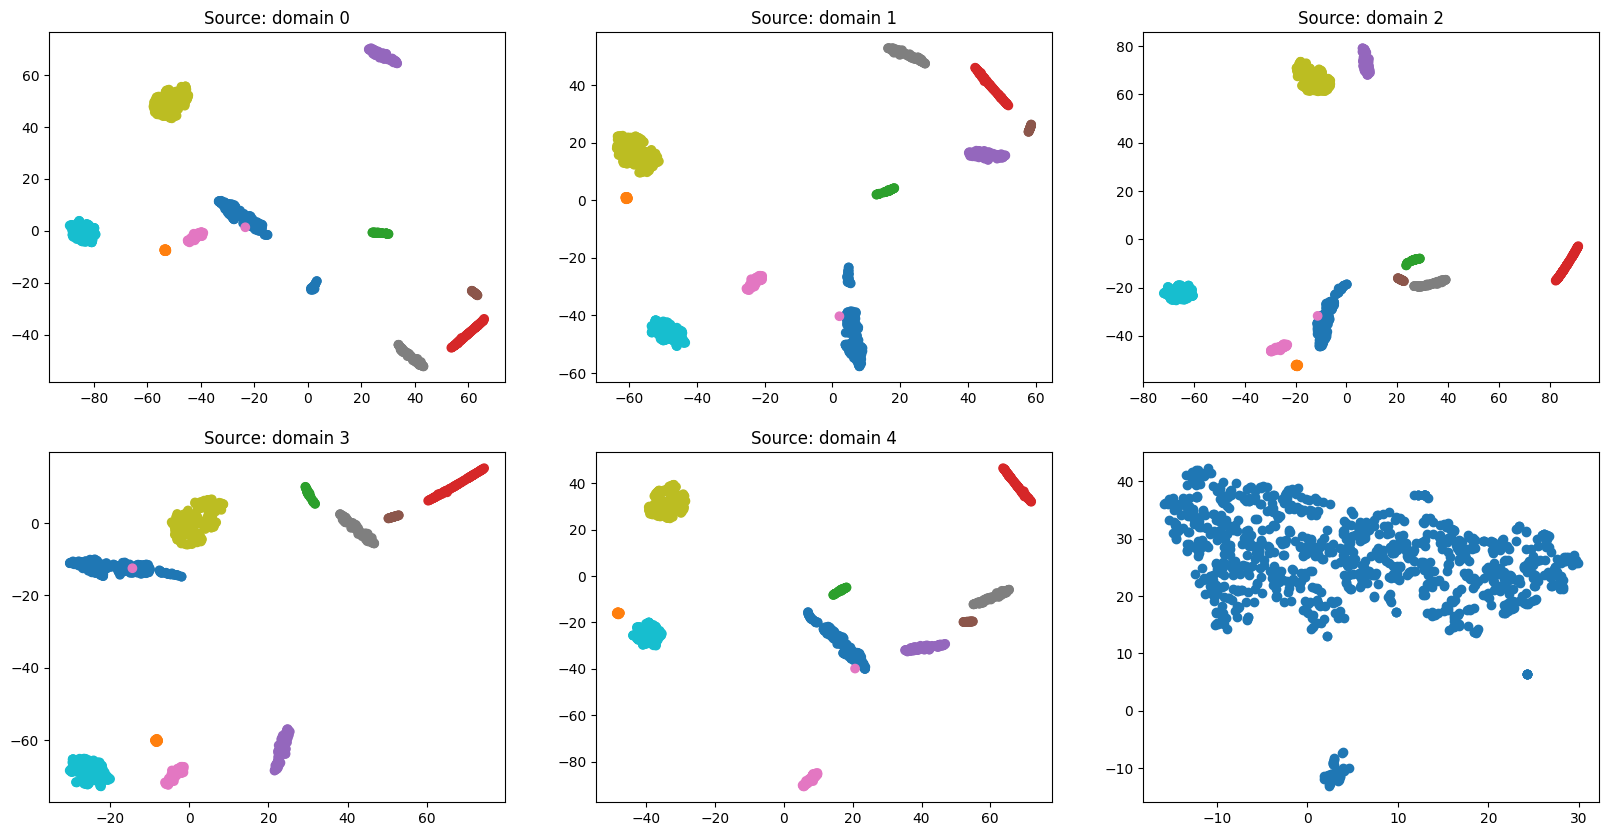

In [ ]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [dictionary_target.OGMM.sample(1000)[0]], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-1]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == n_domains-1)[0]
axes.flatten()[-1].scatter(proj[ind, 0],
               proj[ind, 1])

In [ ]:
weights = dictionary_target.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary_target.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary_target.YP]

Xr, Yr = dictionary_target.reconstruct(weights=weights)

tensor([0.4164, 0.3304, 0.2532])


Classification without DA

In [95]:
clf = SVC(kernel='rbf')
clf = RandomForestClassifier(criterion='gini')

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.761


DaDiL-E

In [97]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(criterion='gini')

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.41600000858306885 got 0.859
Atom 1 w/ weight 0.33000001311302185 got 0.72
Atom 2 w/ weight 0.2529999911785126 got 0.777
0.769


DaDiL-R

In [99]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.829


Final optimal transport to adapt domains

In [93]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    Xt_OGMM = OGMM.sample(XP_k.shape[0])[0]

    weights_k = torch.ones(XP_k.shape[0])/XP_k.shape[0]
    weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

    C = torch.cdist(XP_k, Xt_OGMM, p=2) ** 2
    ot_plan = ot.emd(weights_k, weights_ogmm, C, numItermax=1000000)
    Yt_OGMM = ot_plan.T @ YP_k

    yt_ogmm = Yt_OGMM.argmax(dim=1)
    
    clf.fit(Xt_OGMM, yt_ogmm)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.41600000858306885 got 0.833
Atom 1 w/ weight 0.33000001311302185 got 0.84
Atom 2 w/ weight 0.2529999911785126 got 0.687
0.842


In [94]:
Xt_OGMM = OGMM.sample(Xr.shape[0])[0]

weights_r = torch.ones(Xr.shape[0])/Xr.shape[0]
weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

C = torch.cdist(Xr, Xt_OGMM, p=2) ** 2
ot_plan = ot.emd(weights_r, weights_ogmm, C, numItermax=1000000)
Yt_OGMM = ot_plan.T @ Yr

clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xt_OGMM, Yt_OGMM.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.828


## Dictionary learning seperated between sources and target

In [148]:
Q_sources = []
for Xs_k, ys_k in zip(Xs, ys):
    Q_sources.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q_target = [OGMM]

Q_sources_and_target = Q_sources + Q_target

In [149]:
criterion = JointWassersteinDistance()

In [150]:
dictionary_sources = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=n_classes,
                           n_components=n_atoms,
                           weight_initialization='uniform',
                           n_distributions=len(Q_sources),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [151]:
dictionary_sources.fit(Q_sources,
               n_iter_max=60,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/60, Loss: 6811.979980468751
It 2/60, Loss: 4561.91826171875
It 3/60, Loss: 2949.80390625
It 4/60, Loss: 2065.2195556640627
It 5/60, Loss: 1713.1765380859374
It 6/60, Loss: 1479.4699951171874
It 7/60, Loss: 1339.6915039062499
It 8/60, Loss: 1276.7452880859373
It 9/60, Loss: 1212.3653076171875
It 10/60, Loss: 1163.9464111328125
It 11/60, Loss: 1132.1940673828124
It 12/60, Loss: 1103.9516357421876
It 13/60, Loss: 1085.3390625000002
It 14/60, Loss: 1080.1459228515625
It 15/60, Loss: 1025.7579223632813
It 16/60, Loss: 1015.3780761718749
It 17/60, Loss: 1000.5501708984375
It 18/60, Loss: 1023.8056274414062
It 19/60, Loss: 992.5769653320314
It 20/60, Loss: 978.8472290039061
It 21/60, Loss: 984.0693725585936
It 22/60, Loss: 972.1728637695312
It 23/60, Loss: 955.9900756835939
It 24/60, Loss: 936.7345458984375
It 25/60, Loss: 922.2802612304687
It 26/60, Loss: 926.8438232421875
It 27/60, Loss: 870.6769287109375
It 28/60, Loss: 842.4213256835936
It 29/60, Loss: 825.437353515625
It 30/60, Loss

In [152]:
XP_sources = dictionary_sources.XP
YP_sources = dictionary_sources.YP

In [153]:
names_sources = [f'domain {i}' for i in range(6)]

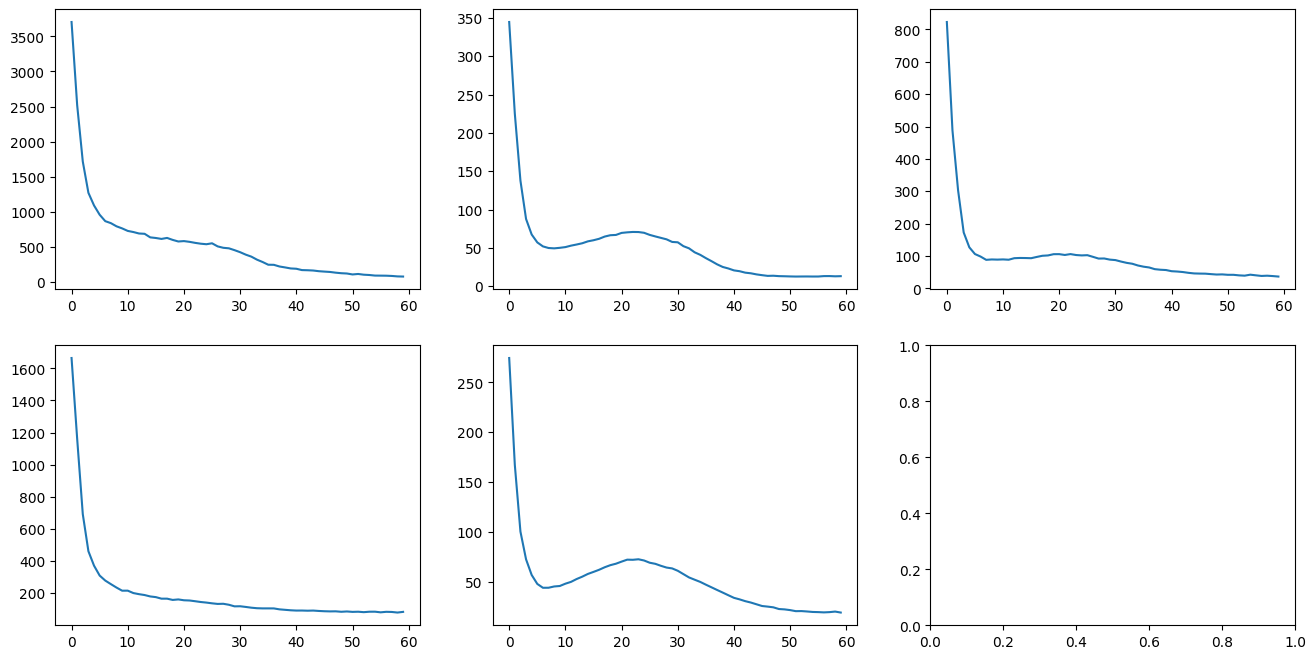

In [154]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary_sources.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary_sources.history['loss_per_dataset'][dom])

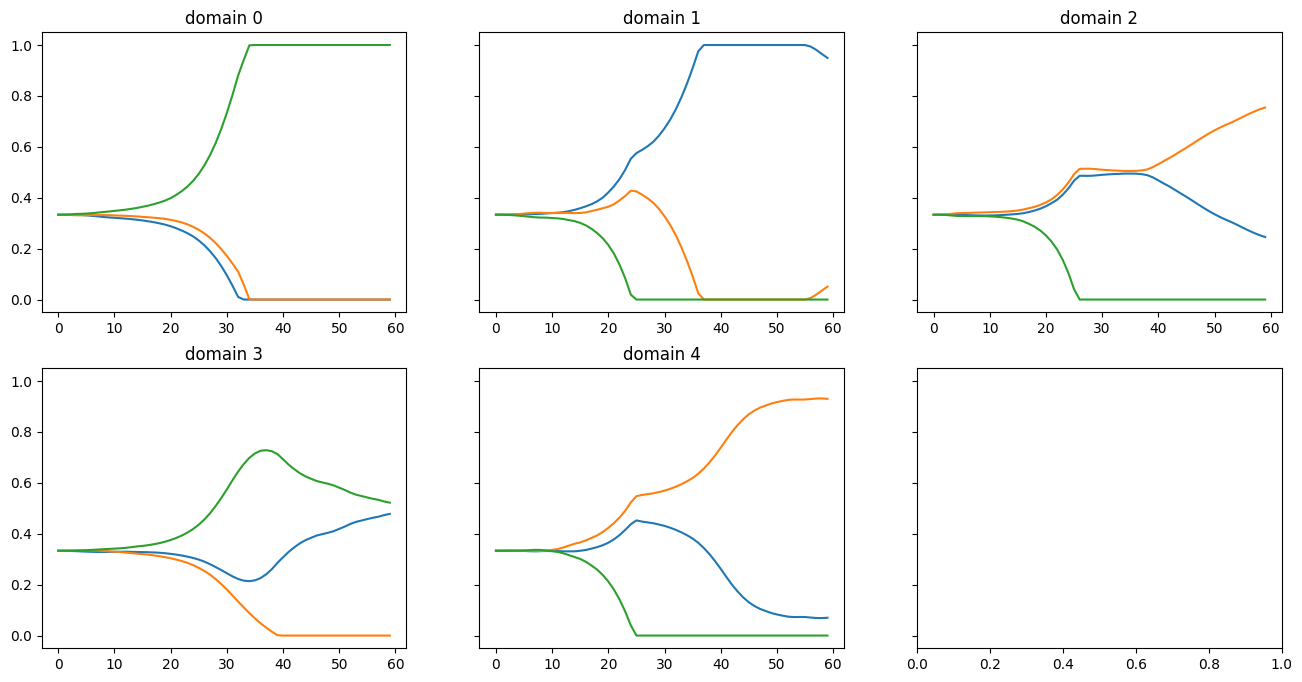

In [155]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names_sources, axes.flatten()[:-1])):
    ax.plot(torch.stack(dictionary_sources.history['weights'])[:, k, :])
    ax.set_title(name)

In [156]:
dictionary_target = LabeledDictionaryGMM(XP=XP_sources,
                           YP=YP_sources,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=n_classes,
                           n_components=n_atoms,
                           weight_initialization='uniform',
                           n_distributions=len(Q_target),
                           loss_fn=criterion,
                           learning_rate_features=0,
                           learning_rate_labels=0,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [157]:
dictionary_target.fit(Q_target,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True,
               regularization=False)

It 1/40, Loss: 105.94940643310547
It 2/40, Loss: 102.3138916015625
It 3/40, Loss: 100.70666351318359
It 4/40, Loss: 104.24326782226564
It 5/40, Loss: 105.36407470703125
It 6/40, Loss: 100.97377319335936
It 7/40, Loss: 105.42977294921874
It 8/40, Loss: 113.99273986816408
It 9/40, Loss: 104.43627166748047
It 10/40, Loss: 105.07008666992188
It 11/40, Loss: 99.160302734375
It 12/40, Loss: 106.98026580810547
It 13/40, Loss: 104.40335540771484
It 14/40, Loss: 100.71348724365234
It 15/40, Loss: 110.29284973144533
It 16/40, Loss: 106.6973907470703
It 17/40, Loss: 111.34894104003907
It 18/40, Loss: 107.89900054931641
It 19/40, Loss: 105.51728515625001
It 20/40, Loss: 108.06456146240235
It 21/40, Loss: 109.65324096679689
It 22/40, Loss: 102.43630828857422
It 23/40, Loss: 96.41658020019531
It 24/40, Loss: 112.88636627197266
It 25/40, Loss: 110.97306213378906
It 26/40, Loss: 112.72770233154297
It 27/40, Loss: 102.13374786376954
It 28/40, Loss: 106.38578033447267
It 29/40, Loss: 101.5913070678711
I

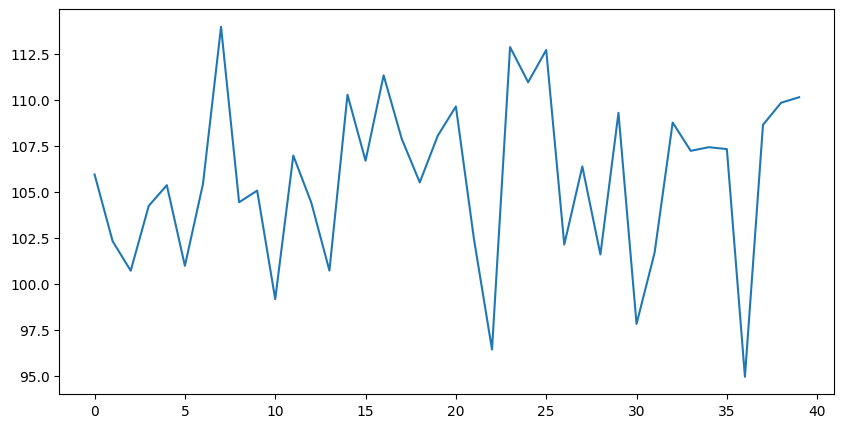

In [158]:
target_name = 'Domain 7'
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dictionary_target.history['loss_per_dataset']['Domain 0'])

Text(0.5, 1.0, 'Domain 7')

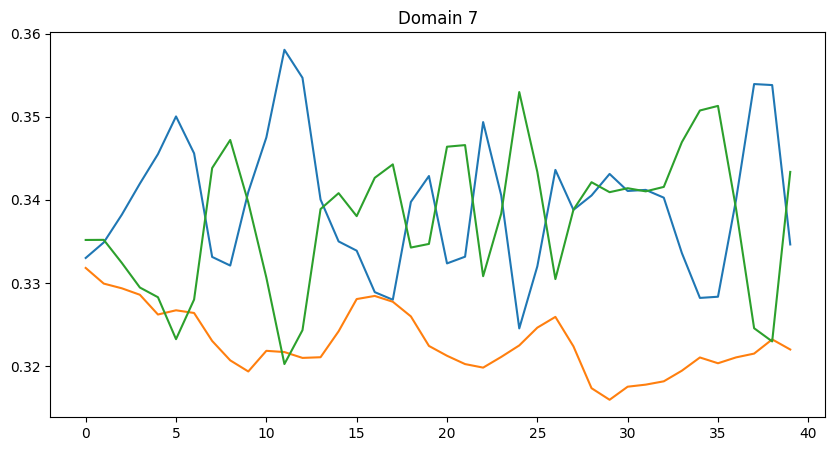

In [159]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(torch.stack(dictionary_target.history['weights'])[:, -1, :])
ax.set_title(target_name)

In [160]:
weights = dictionary_target.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary_target.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary_target.YP]

tensor([0.3346, 0.3220, 0.3434])


In [161]:
Xr, Yr = dictionary_target.reconstruct(weights=weights)

Classification without DA

In [162]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'gini')
clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.611


DaDiL-E

In [176]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(criterion = 'gini')

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.33500000834465027 got 0.168
Atom 1 w/ weight 0.32199999690055847 got 0.478
Atom 2 w/ weight 0.34299999475479126 got 0.521
0.435


DaDiL-R

In [183]:
clf = SVC(kernel='linear')
clf = RandomForestClassifier(criterion = 'gini')

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.49


Final optimal transport to adapt domains

In [171]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    Xt_OGMM = OGMM.sample(XP_k.shape[0])[0]

    weights_k = torch.ones(XP_k.shape[0])/XP_k.shape[0]
    weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

    C = torch.cdist(XP_k, Xt_OGMM, p=2) ** 2
    ot_plan = ot.emd(weights_k, weights_ogmm, C, numItermax=1000000)
    Yt_OGMM = ot_plan.T @ YP_k

    yt_ogmm = Yt_OGMM.argmax(dim=1)
    
    clf.fit(Xt_OGMM, yt_ogmm)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.33500000834465027 got 0.436
Atom 1 w/ weight 0.32199999690055847 got 0.701
Atom 2 w/ weight 0.34299999475479126 got 0.681
0.722


In [175]:
Xt_OGMM = OGMM.sample(Xr.shape[0])[0]

weights_r = torch.ones(Xr.shape[0])/Xr.shape[0]
weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

C = torch.cdist(Xr, Xt_OGMM, p=2) ** 2
ot_plan = ot.emd(weights_r, weights_ogmm, C, numItermax=1000000)
Yt_OGMM = ot_plan.T @ Yr

clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xt_OGMM, Yt_OGMM.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.658


## Classic Dictionary learning with Online_GMM

In [ ]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(OGMM)

criterion = JointWassersteinDistance()

dictionary = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=n_classes,
                           n_components=n_atoms,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

dictionary.fit(Q,
               n_iter_max=200,
               batches_per_it=n_samples // batch_size,
               verbose=True,
               sklearn_GMM=False,
               batch_size_GMM=batch_size)

In [53]:
dictionary.fit(Q,
               n_iter_max=25,
               batches_per_it=n_samples // batch_size,
               verbose=True,
               sklearn_GMM=False,
               batch_size_GMM=batch_size)

It 1/25, Loss: 2417585.75
It 2/25, Loss: 2411101.05
It 3/25, Loss: 2374523.35
It 4/25, Loss: 2357265.8
It 5/25, Loss: 2369909.0
It 6/25, Loss: 2313205.15
It 7/25, Loss: 2337655.5
It 8/25, Loss: 2319635.35
It 9/25, Loss: 2255849.5500000003
It 10/25, Loss: 2262583.4
It 11/25, Loss: 2224409.25
It 12/25, Loss: 2203166.6
It 13/25, Loss: 2185808.4250000003
It 14/25, Loss: 2193509.0000000005
It 15/25, Loss: 2156737.65
It 16/25, Loss: 2159978.0
It 17/25, Loss: 2175492.55
It 18/25, Loss: 2142522.6999999997
It 19/25, Loss: 2140391.0
It 20/25, Loss: 2108673.4499999997
It 21/25, Loss: 2130635.775
It 22/25, Loss: 2073217.725
It 23/25, Loss: 2065358.85
It 24/25, Loss: 2071870.175
It 25/25, Loss: 2077441.775


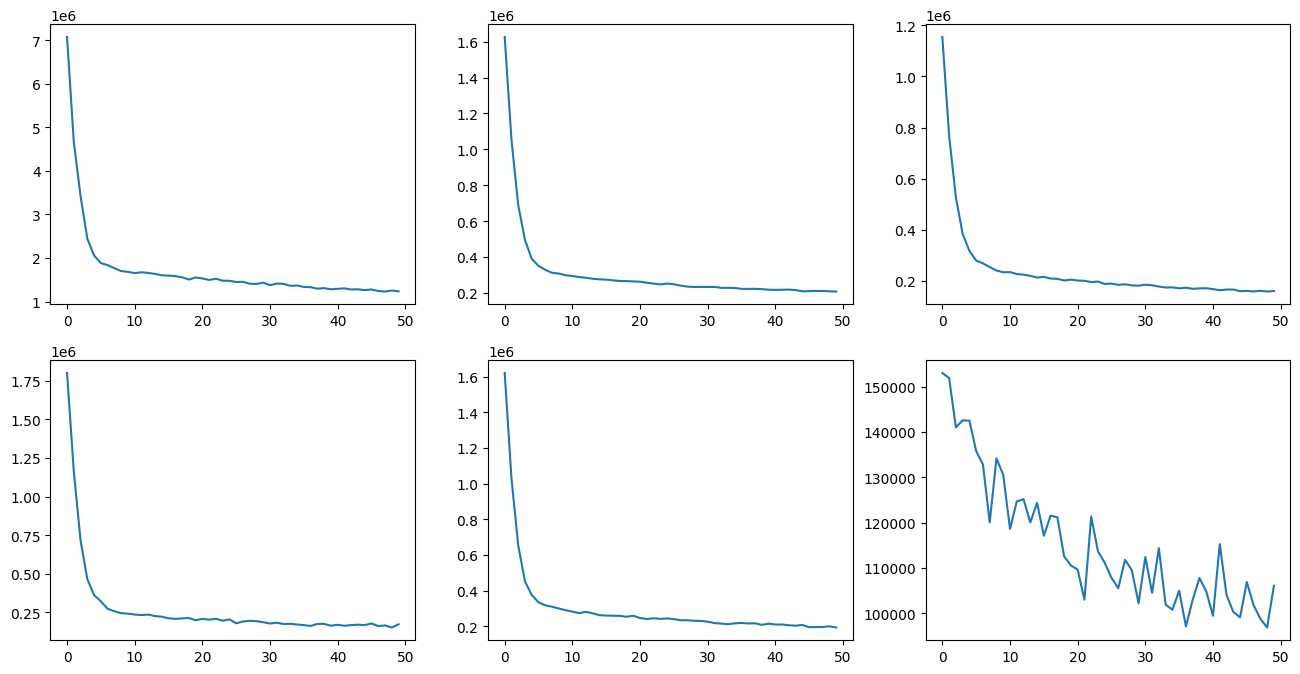

In [54]:
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][dom])

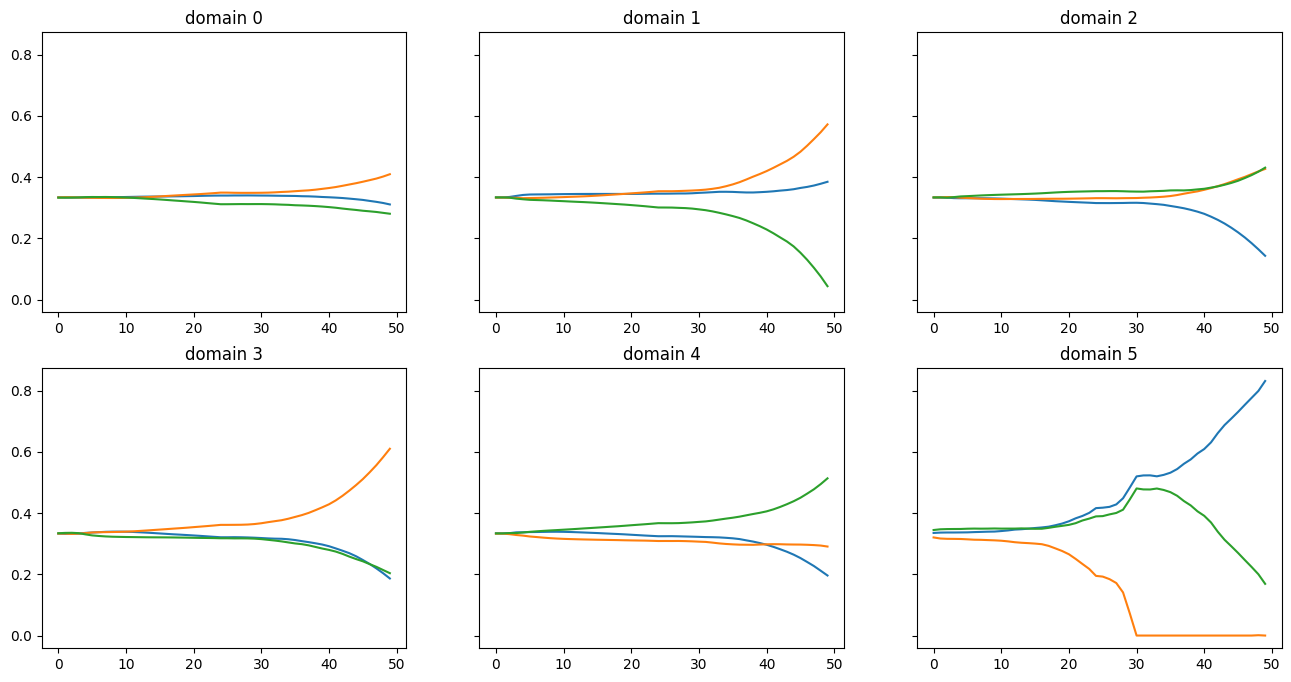

In [55]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)

In [56]:
weights = dictionary.A[-1, :].detach()
#weights = torch.tensor([1/3, 1/3, 1/3])
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

Xr, Yr = dictionary.reconstruct(weights=weights)

tensor([0.8311, 0.0000, 0.1689])


Classification without DA

In [57]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier()

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.611


DaDiL-E

In [63]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(criterion = 'gini')

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.8309999704360962 got 0.591
Atom 1 w/ weight 0.0 got 0.51
Atom 2 w/ weight 0.16899999976158142 got 0.562
0.586


DaDiL-R

In [59]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier()

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.785


Final optimal transport to adapt domains

In [60]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    Xt_OGMM = OGMM.sample(XP_k.shape[0])[0]

    weights_k = torch.ones(XP_k.shape[0])/XP_k.shape[0]
    weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

    C = torch.cdist(XP_k, Xt_OGMM, p=2) ** 2
    ot_plan = ot.emd(weights_k, weights_ogmm, C, numItermax=1000000)
    Yt_OGMM = ot_plan.T @ YP_k

    yt_ogmm = Yt_OGMM.argmax(dim=1)
    
    clf.fit(Xt_OGMM, yt_ogmm)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.8309999704360962 got 0.925
Atom 1 w/ weight 0.0 got 0.829
Atom 2 w/ weight 0.16899999976158142 got 0.934
0.941


In [61]:
Xt_OGMM = OGMM.sample(Xr.shape[0])[0]

weights_r = torch.ones(Xr.shape[0])/Xr.shape[0]
weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

C = torch.cdist(Xr, Xt_OGMM, p=2) ** 2
ot_plan = ot.emd(weights_r, weights_ogmm, C, numItermax=1000000)
Yt_OGMM = ot_plan.T @ Yr

clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xt_OGMM, Yt_OGMM.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.944


## Classic Dictionary Learning

In [18]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(
    UnsupervisedDatasetMeasure(
        features=Xt.numpy(),
        batch_size=batch_size,
        device='cpu'
    )
)

In [19]:
criterion = JointWassersteinDistance()

In [20]:
dictionary = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=n_classes,
                           n_components=n_atoms,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [21]:
dictionary.fit(Q,
               n_iter_max=200,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/200, Loss: 13188946.799999999
It 2/200, Loss: 8776185.299999999
It 3/200, Loss: 5981083.1
It 4/200, Loss: 4473066.2
It 5/200, Loss: 3693153.6999999997
It 6/200, Loss: 3278631.8
It 7/200, Loss: 3112970.3
It 8/200, Loss: 3010784.3000000003
It 9/200, Loss: 2922958.65
It 10/200, Loss: 2835358.9500000007
It 11/200, Loss: 2796034.5999999996
It 12/200, Loss: 2794618.1
It 13/200, Loss: 2788625.0
It 14/200, Loss: 2752859.95
It 15/200, Loss: 2701647.6500000004
It 16/200, Loss: 2636908.65
It 17/200, Loss: 2641881.65
It 18/200, Loss: 2630988.6
It 19/200, Loss: 2606665.35
It 20/200, Loss: 2549954.3
It 21/200, Loss: 2478534.75
It 22/200, Loss: 2499899.6
It 23/200, Loss: 2477137.1
It 24/200, Loss: 2448043.75
It 25/200, Loss: 2454305.6
It 26/200, Loss: 2452767.9
It 27/200, Loss: 2401653.3000000003
It 28/200, Loss: 2423254.8
It 29/200, Loss: 2380100.25
It 30/200, Loss: 2361671.6999999997
It 31/200, Loss: 2327910.75
It 32/200, Loss: 2371114.6999999997
It 33/200, Loss: 2320040.25
It 34/200, Loss: 23

In [22]:
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

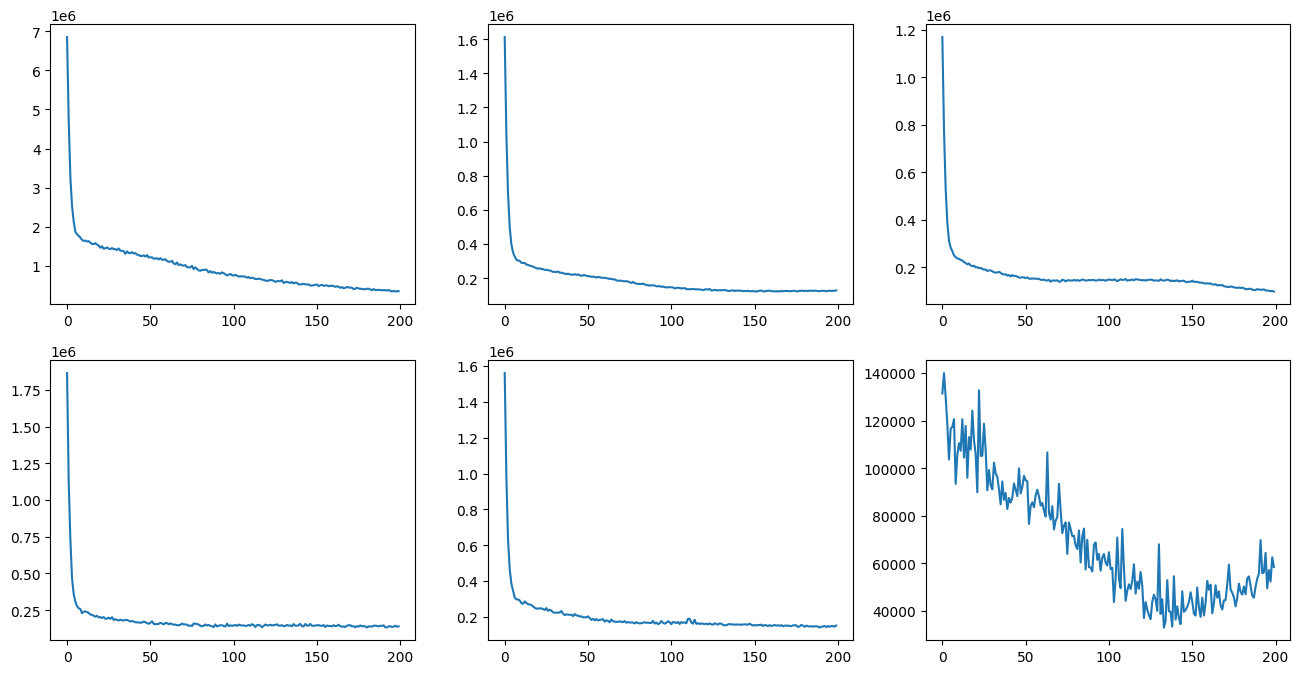

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][dom])

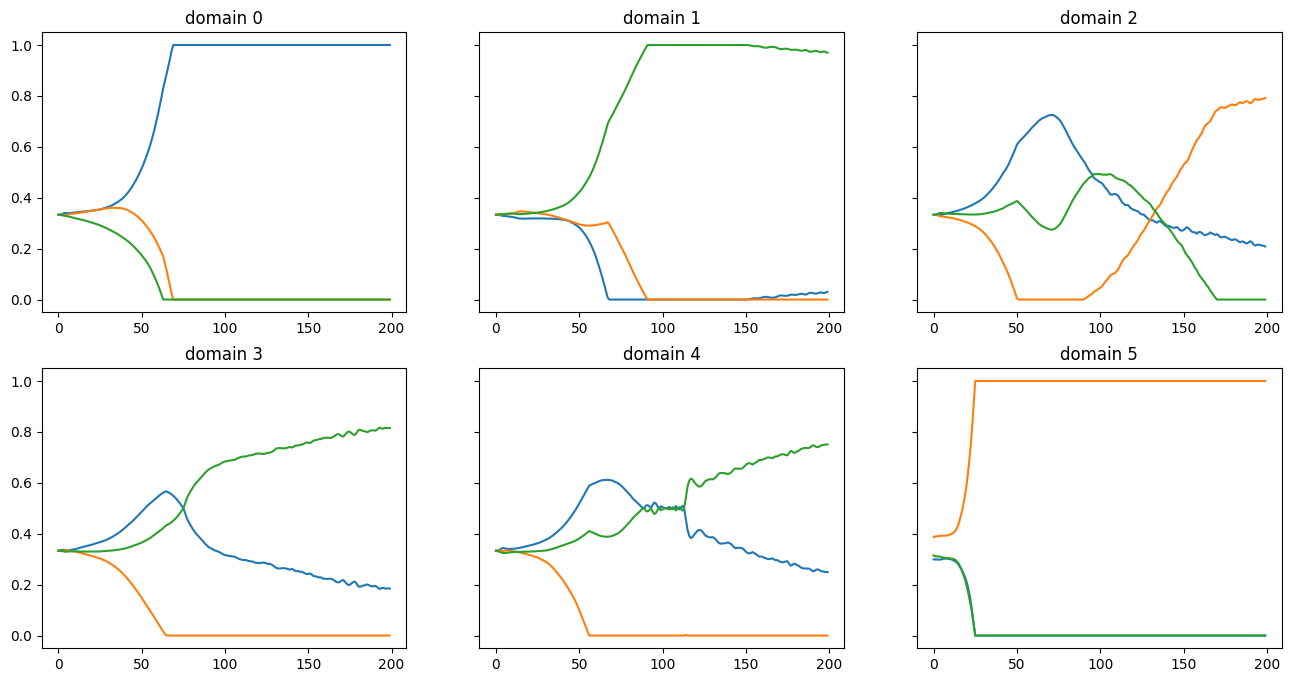

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)

In [25]:
weights = dictionary.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

Xr, Yr = dictionary.reconstruct(weights=weights)

tensor([0., 1., 0.])


Classification without DA

In [42]:
clf = SVC(kernel='linear')
clf = RandomForestClassifier()

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.613


DaDiL-E

In [34]:
clf = SVC(kernel='rbf', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

'''
yp = [np.sum((weights.numpy().reshape(-1, 1) * predictions[:, j, :]), axis = 0).argmax() for j in range(predictions.shape[1])]
yp = np.array(yp)
'''

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.0 got 0.378
Atom 1 w/ weight 1.0 got 0.608
Atom 2 w/ weight 0.0 got 0.072
0.601


DaDiL-R

In [35]:
clf = SVC(kernel='rbf')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.608


Final optimal transport to adapt domains

In [41]:
clf = SVC(kernel='rbf', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()

    weights_k = torch.ones(XP_k.shape[0])/XP_k.shape[0]
    weights_t = torch.ones(Xt.shape[0])/Xt.shape[0]

    C = torch.cdist(XP_k, Xt, p=2) ** 2
    ot_plan = ot.emd(weights_k, weights_t, C, numItermax=1000000)
    Yt = ot_plan.T @ YP_k

    yt_k = Yt.argmax(dim=1)
    
    clf.fit(Xt, yt_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.0 got 0.704
Atom 1 w/ weight 1.0 got 0.841
Atom 2 w/ weight 0.0 got 0.47
0.728


In [40]:
weights_r = torch.ones(Xr.shape[0])/Xr.shape[0]
weights_t = torch.ones(Xt.shape[0])/Xt.shape[0]

C = torch.cdist(Xr, Xt, p=2) ** 2
ot_plan = ot.emd(weights_r, weights_t, C, numItermax=1000000)
Yt = ot_plan.T @ Yr

clf = SVC(kernel='rbf')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xt, Yt.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.841
